In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import pandas as pd
from types import SimpleNamespace

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

/home/rajiv/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


solenoid_commanded
0.0      509.975
1.0      509.975
2.0      509.950
3.0      509.975
4.0      509.975
          ...   
251.0    577.700
252.0    578.650
253.0    578.950
254.0    579.350
255.0    579.000
Name: analog value (1-1024) (raw), Length: 256, dtype: float64


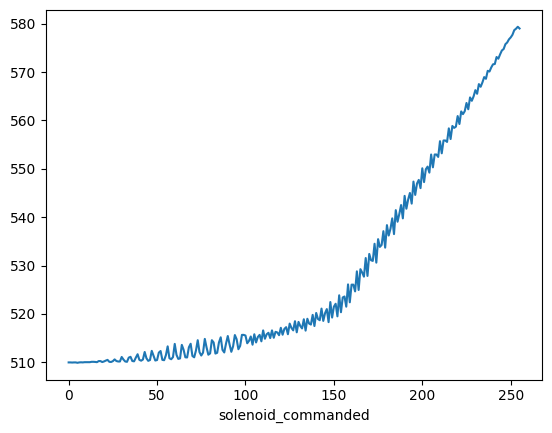

In [39]:
sensor_data = pd.read_csv("pin_5_6_solenoid_correction.csv")
# sensor_data = sensor_data.truncate(before=400, after=5550)
sensor_data.drop(sensor_data.columns[3], axis=1, inplace=True)

# Drop rows with NaN values in "solenoid_commanded" column
df_short_solenoid = sensor_data['solenoid_commanded'].dropna()
# Drop rows with NaN values in "analog value (1-1024) (raw)" column
df_short_analog = sensor_data['analog value (1-1024) (raw)'].dropna()
df_short_analog.index = df_short_solenoid.index
# Merge the shortened DataFrames based on the index
df_shortened = pd.concat([df_short_solenoid, df_short_analog],axis=1)

# Group by "solenoid_commanded" and calculate the average of "analog value (1-1024) (raw)"
average_values = df_shortened.groupby('solenoid_commanded')['analog value (1-1024) (raw)'].mean()
average_values.plot()
# sensor_data.drop(sensor_data.columns[0], axis=1, inplace=True)

# if interpolating
# sensor_data = sensor_data.interpolate()

# if droppi"analog value (1-1024) (raw)"ng na values and collapsing
# sensor_data["analog value (1-1024) (raw)"] = sensor_data["analog value (1-1024) (raw)"][sensor_data["analog value (1-1024) (raw)"].notna()]
# sensor_data["solenoid_commanded"] = sensor_data["solenoid_commanded"][sensor_data["solenoid_commanded"].notna()]

# mean_window = 50
# sensor_data["analog average"] = sensor_data["analog value (1-1024) (raw)"].rolling(mean_window).mean().shift(-mean_window//2)
# sensor_data.dropna(inplace = True)

# sensor_data.plot()
# sensor_data.plot(x="solenoid_commanded", y="analog value (1-1024) (raw)")
# sensor_data.plot(x="solenoid_commanded", y="analog average")

print(average_values)

Linear regression between 155 and 255: slope = 0.5806, intercept = 432
Linear regression between 50 and 155: slope = 0.0952, intercept = 505


Text(0, 0.5, 'Hall effect sensor reading (0-1023)')

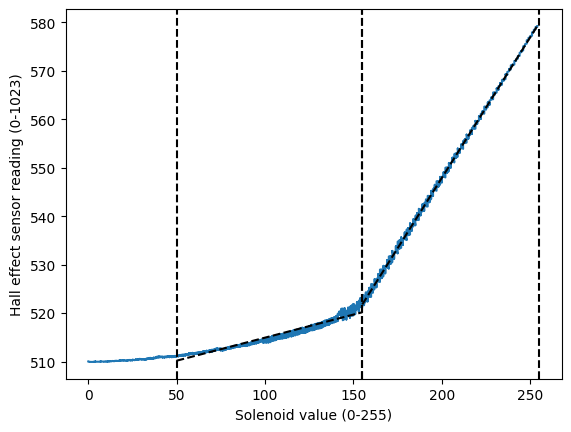

In [48]:
class LinearRegressionRegion():
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.range = (self.start <= sensor_data["solenoid_commanded"]) & (sensor_data["solenoid_commanded"] <= self.end) & sensor_data["solenoid_commanded"].notnull()

        # linear regression
        A = np.vstack([sensor_data["solenoid_commanded"][self.range], np.ones(len(sensor_data["solenoid_commanded"][self.range]))]).T
        self.slope, self.intercept = np.linalg.lstsq(A, sensor_data["analog average"][self.range], rcond=None)[0]
        self.print_values()

    def plot(self):
        plt.axvline(x = self.start, color = "black", linestyle = "dashed")
        plt.axvline(x = self.end, color = "black", linestyle = "dashed")
        plt.plot(sensor_data["solenoid_commanded"][self.range], sensor_data["solenoid_commanded"][self.range] * self.slope + self.intercept, color = "black", linestyle = "dashed")

    def print_values(self):
        print(f"Linear regression between {self.start} and {self.end}: slope = {self.slope:.4f}, intercept = {self.intercept:.0f}")

plt.plot(sensor_data["solenoid_commanded"], sensor_data["analog average"])
region_1 = LinearRegressionRegion(start = 155, end = 255)
region_1.plot()
region_2 = LinearRegressionRegion(start = 50, end = 155)
region_2.plot()
plt.xlabel("Solenoid value (0-255)")
plt.ylabel("Hall effect sensor reading (0-1023)")